In [1]:
!pip install rich

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
from concurrent.futures import ProcessPoolExecutor, as_completed
from collections import defaultdict
from matplotlib.lines import Line2D


In [4]:
BASE_DIR = "/content/drive/MyDrive/MLDL/6D-Pose-Estimation"

### **Loading Data**

In [5]:
#CPS pairs
KP3D_CPS_JSON = os.path.join(BASE_DIR, "data/point_sampling_data/3D_50_keypoints_cps.json")
KP2D_CPS_JSON = os.path.join(BASE_DIR, "data/predicted_key_points/2D_predicted_resnet18_keypoints50_cps_focalloss.json")

#FPS pairs
KP3D_FPS_JSON = os.path.join(BASE_DIR, "data/point_sampling_data/3D_50_keypoints_fps.json")
KP2D_FPS_JSON = os.path.join(BASE_DIR, "data/predicted_key_points/2D_predicted_resnet18_keypoints50_fps_focalloss.json")

YOLO_LABEL_DIR = os.path.join(BASE_DIR, "models/yolov10m/bbox_predictions/labels/")
GT_JSON = os.path.join(BASE_DIR, "data/full_data/train/gt.json")


#loading gt data with rotation and translation
with open(GT_JSON, "r") as f:
  gt_data = json.load(f)


#loading 50cps 3D points
with open(KP3D_CPS_JSON, "r") as f:
  kp3d_50_cps = json.load(f)

#loading 50fps 3D points
with open(KP3D_FPS_JSON, "r") as f:
  kp3d_50_fps = json.load(f)


# #loading 50 cps points
with open(KP2D_CPS_JSON, "r") as f:
  kp2d_50_cps = json.load(f)

# #loading 50 fps points
with open(KP2D_FPS_JSON, "r") as f:
  kp2d_50_fps = json.load(f)

### **Transforming keypoints**

In [6]:
# ─── CONSTANTS ─────────────────────────────────────────────────────────────────

ORIG_W, ORIG_H = 640.0, 480.0   # original image size
CROP_W, CROP_H = 256.0, 256.0   # YOLO‐cropped size

#First we need to convert keypoints to original images format -> SCALLING THEM BY CROP_SIZE/256, then to shift with respect to bounding box coordinate

def transfrom_keypoints(img_id, keypoints):

    #Reading bounding box data from YOLO output
    lbl = os.path.join(YOLO_LABEL_DIR, f"{img_id}.txt")
    if not os.path.isfile(lbl):
        return None
    with open(lbl) as f:
        parts = f.readline().split()
    if len(parts) != 5:
        return None

    pred_class, xc, yc, w, h = map(float, parts)
    # Convert normalized → absolute pixel bbox
    x = (xc - w / 2) * ORIG_W
    y = (yc - h / 2) * ORIG_H
    w *= ORIG_W
    h *= ORIG_H

    scale_x =  w / CROP_W
    scale_y = h / CROP_H

    pts_full = []
    for u_crop, v_crop in keypoints:
        u_full = (u_crop * scale_x) + x
        v_full = (v_crop * scale_y) + y

        pts_full.append([u_full, v_full])
    return pts_full


### **Plotting transformed keypoints**##

In [7]:
def visualize_one_per_class(keypoints_data, image_dir, gt_keypoints_data=None, orig=False):
    shown_classes = set()

    for key, keypoints in keypoints_data.items():
        class_str = key.split('_')[0]
        class_id = class_str

        if class_id is None or class_id in shown_classes:
            continue

        # transform for original image
        if orig:
            keypoints = transfrom_keypoints(key, keypoints)
            if gt_keypoints_data is not None and key in gt_keypoints_data:
                gt_keypoints = transfrom_keypoints(key, gt_keypoints_data[key])
            else:
                gt_keypoints = []
        else:
            gt_keypoints = gt_keypoints_data.get(key, []) if gt_keypoints_data else []

        # load image
        img_path = os.path.join(image_dir, f"{key}.png")
        image = cv2.imread(img_path)
        if image is None:
            print(f"[ERROR] Image not found: {img_path}")
            continue

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # plot predicted keypoints (blue)
        for x, y in keypoints:
            cv2.circle(image, (int(x), int(y)), 3, (255, 0, 0), -1)

        # plot GT keypoints (green)
        for xg, yg in gt_keypoints:
            cv2.circle(image, (int(xg), int(yg)), 3, (0, 255, 0), -1)

        # show
        plt.figure(figsize=(4, 4))
        plt.imshow(image)
        plt.title(f"{key} (class {class_id})")
        plt.axis('off')
        plt.show()

        shown_classes.add(class_id)
        if len(shown_classes) == 13:
            break


### **Observations**:

- Transforming keypoints is performed correctly
- Now it's important to match them correctly with corresponding 3D points, so we are sure that PnP is also applied correctly

### **PNP**

In [8]:
def eliminate_duplicate_pairs(pts2d, pts3d):

  pairs = list(zip(pts3d, pts2d))
  unique_pairs = []
  seen_2d = set()

  for p3d, p2d in pairs:
      key = tuple(np.round(p2d))

      if key in seen_2d:
          continue

      seen_2d.add(key)
      unique_pairs.append((p3d, p2d))

  # Ako imamo manje od 4 unikatna para, ne može solvePnP
  if len(unique_pairs) < 4:
      print(f"[WARNING] Not enough unique 2D keypoints after deduplication")
      return None


  pts3d_clean = np.array([p3d for p3d, _ in unique_pairs], dtype=np.float64)
  pts2d_clean = np.array([p2d for _, p2d in unique_pairs], dtype=np.float64)

  # print(pts2d_clean)

  return pts2d_clean, pts3d_clean


In [9]:
# ─── CONSTANTS ─────────────────────────────────────────────────────────────────
K = np.array([
    [572.4114,   0.0,      325.2611],
    [  0.0,    573.57043,  242.04899],
    [  0.0,      0.0,        1.0   ]
], dtype=np.float64)

def run_pnp(item, kp3d):
  img_id, keypoints = item

  # print(img_id, len(keypoints))

  # recover full‐image 2D keypoints
  transformed_keypoints = transfrom_keypoints(img_id, keypoints)

  if transformed_keypoints is None:
      print(item)
      return None

  # select 3D model
  obj_key = img_id.split("_")[0]

  pts3d = np.array(kp3d[obj_key])
  pts2d = np.array(transformed_keypoints, np.float64)


  #this call is for eliminating duplicate points, but it does not solve out issue
  pts2d, pts3d = eliminate_duplicate_pairs(pts2d, pts3d)

  success, rvec, tvec, inliers = cv2.solvePnPRansac(
      objectPoints = pts3d,
      imagePoints = pts2d,
      cameraMatrix = K,
      distCoeffs = None,
      reprojectionError = 5,      # Very high threeshold, it was 15, after 5, #I tried  1 and 3, worse results
      confidence = 0.99,  #
      flags = cv2.SOLVEPNP_ITERATIVE
  )


  if not success:
    #Solution could not be found under this reprojection error
      return None

  R_mat, _ = cv2.Rodrigues(rvec)
  return img_id, {"R": R_mat.tolist(), "t": tvec.flatten().tolist()}, inliers

In [10]:
def safe_run_pnp(t, kp3d):
      try:
          return run_pnp(t, kp3d)
      except Exception as e:
          print(f"[ERROR] {t[0]}: {e}")
          return None

def run_parallel_pnp(kp, kp3d):

    tasks = list(kp.items())
    pnp_results_pred = {}
    skipped = 0

    print(kp3d)

    with ProcessPoolExecutor() as executor:
        futures = {executor.submit(safe_run_pnp, t, kp3d): t for t in tasks}

        for future in tqdm(as_completed(futures), total=len(futures), desc="Running PnP"):
            result = future.result()
            if result is None:
                skipped += 1
            else:
                img_id, pose, inliers = result
                pnp_results_pred[img_id] = (pose, inliers)

    return pnp_results_pred, skipped

### **Execution of PnP**

#### Perform PNP for both CPS and FPS predictions

In [11]:
#CPS predictions
pnp_results_pred_cps, skipped_pred_cps = run_parallel_pnp(kp2d_50_cps, kp3d_50_cps)
print(f"\nTotal skipped: {skipped_pred_cps}")


#FPS predictions
pnp_results_pred_fps, skipped_pred_fps = run_parallel_pnp(kp2d_50_fps, kp3d_50_fps)
print(f"\nTotal skipped: {skipped_pred_fps}")

{'01': [[37.4058, -13.9062, -43.9045], [17.1262, 5.9327, 34.3588], [2.3858, 36.4856, -16.959], [28.4373, -27.2661, -5.8485], [-11.7938, -24.2389, -43.3171], [17.4448, 13.9151, -39.0463], [-6.9367, -17.2858, 20.2513], [-22.8585, 13.4352, -43.386], [10.864, 20.7981, 7.5068], [5.5818, -37.8016, -24.1337], [16.8932, -11.1798, -27.1113], [4.7401, -27.55, 0.7501], [-16.8918, 24.7676, 2.968], [18.7807, -4.8824, 10.0671], [-11.454, 1.3232, 43.2569], [6.853, 14.9262, -20.7135], [-10.5129, -26.8211, -14.1854], [-13.4719, 23.9908, -16.5481], [4.5865, 18.112, 25.3786], [23.693, -24.7517, -37.1354], [9.4932, -16.0251, -11.0569], [30.5248, 0.8223, -34.1492], [3.6027, -13.4213, 8.6992], [29.433, -20.5311, -20.9767], [9.3754, 5.2394, 2.5797], [-30.546, -9.0249, -42.0481], [15.3405, 4.7172, -27.3592], [13.8588, -9.0099, 25.9046], [13.4378, 27.9836, -27.6088], [9.9842, 25.4651, -7.1681], [-20.7917, 6.6055, 21.0072], [17.8163, 9.5214, 15.1107], [-6.2431, 35.7826, -3.6512], [6.549, -17.8114, -43.8661], [-

Running PnP: 100%|██████████| 2843/2843 [08:16<00:00,  5.73it/s]


Total skipped: 0
{'01': [[19.486, 7.7444, -29.6305], [-7.3779, 0.294, 45.245], [-35.7304, -10.6496, -14.8147], [8.7706, -35.5061, -3.2386], [-10.9594, 27.5355, 3.661], [-6.4447, -26.1651, -42.9172], [-19.6192, 16.6733, -43.0962], [21.5434, 1.0534, 13.4177], [-15.3126, -17.087, 15.4306], [3.569, 37.4597, -25.3263], [32.0877, -20.3823, -43.4858], [30.5224, -20.9363, -14.3889], [-29.2756, -10.2832, -42.6256], [2.8027, 18.3123, 25.8623], [-26.3661, 15.7481, -16.3645], [-13.1523, -26.3488, -16.8868], [-26.4575, 6.078, 8.5464], [0.5324, -1.0966, -45.28], [7.8592, 12.3693, -5.5813], [12.994, -34.1667, -29.0041], [5.5824, -12.7082, 28.137], [9.2725, -11.6225, -8.4472], [2.6858, 21.3465, -41.231], [16.9972, 4.3673, 34.9224], [-17.4156, 9.4466, 27.8551], [6.7953, 33.2112, -4.8945], [-35.2317, 5.8738, -31.6641], [11.9252, -18.0259, -44.1497], [-14.3831, 29.2467, -27.7025], [16.8932, -11.1798, -27.1113], [26.489, -2.3052, -44.3766], [2.5196, -15.4878, 8.7331], [-22.9883, -20.5136, -1.9573], [-24.


Running PnP: 100%|██████████| 2843/2843 [00:18<00:00, 153.02it/s]


Total skipped: 0


### **Evaluating results** Measuring ADD




In [109]:
diameter_map = {
    '01': 102.09865663,
    '02': 247.50624233,
    '03': 167.35486092,
    '04': 172.49224865,
    '05': 201.40358597,
    '06': 154.54551808,
    '07': 124.26430816,
    '08': 261.47178102,
    '09': 108.99920102,
    '10': 164.62758848,
    '11': 175.88933422,
    '12': 145.54287471,
    '13': 278.07811733,
    '14': 282.60129399,
    '15': 212.35825148
}

symmetric_objects = {'10', '11'}  #eggbox (10) and glue (11) are symmetric objects in linemod dataset

def get_gt_pose(img_id):
    entry = gt_data[img_id]
    R_list, t_list = entry[0], entry[1]
    R = np.array(R_list, float).reshape(3, 3)
    t = np.array(t_list, float).flatten().reshape(3, 1)
    return R, t


def evaluate_pose_estimation(pnp_results,
                             kp3d,
                             diameter_map,
                             threshold_ratio=0.1):

    correct_by_class = defaultdict(int)
    total_by_class   = defaultdict(int)
    results_distribution_class = defaultdict(list)
    high_error_samples = defaultdict(list)


    for img_id, (est, _) in pnp_results.items():
        cls = img_id.split("_")[0]

        # if cls not in kp3d or cls not in diameter_map:
        #     continue
        try:
            Rg, tg = get_gt_pose(img_id)
        except KeyError:
            continue

        Rp = np.array(est["R"], dtype=float)
        tp = np.array(est["t"], dtype=float).reshape(3, 1)

        # project keypoints
        pts3d = np.array(kp3d[cls], dtype=np.float32)  # (N,3)
        gt_tr  = (Rg @ pts3d.T + tg).T                 # (N,3)
        pnp_tr = (Rp @ pts3d.T + tp).T                 # (N,3)


        if cls in symmetric_objects:

        # ADD-S: minimal distance between each GT point and closest predicted
          add_s_err = np.mean([
              np.min(np.linalg.norm(gt_point - pnp_tr, axis=1))
              for gt_point in gt_tr
          ])
          add_err = add_s_err
        else:
          # standard ADD
          add_err = np.mean(np.linalg.norm(gt_tr - pnp_tr, axis=1))

        total_by_class[cls] += 1

        results_distribution_class[cls].append(add_err/diameter_map[cls])

        # print(add_err)
        if add_err < threshold_ratio * diameter_map[cls]:
            correct_by_class[cls] += 1
        else:
            high_error_samples[cls].append((img_id, add_err))



    # compute accuracy percentages
    accuracy_results = {cls: 100.0 * correct_by_class[cls] / total_by_class[cls]
        for cls in total_by_class
    }


    #sorting bad results
    for cls in high_error_samples:
      high_error_samples[cls].sort(key=lambda x: x[1], reverse=True)

    return accuracy_results, results_distribution_class, high_error_samples

### Final ADD results

In [110]:
accurracy_cps, results_distribution_cps, high_error_samples_cps = evaluate_pose_estimation(pnp_results_pred_cps,
                                    kp3d_50_cps,
                                    diameter_map,
                                    threshold_ratio=0.1)

accurracy_fps, results_distribution_fps, high_error_samples_fps = evaluate_pose_estimation(pnp_results_pred_fps,
                                    kp3d_50_fps,
                                    diameter_map,
                                    threshold_ratio=0.1)

print("Results for CPS: ")
for cls, acc in accurracy_cps.items():
  print(f"Class {cls}: {acc:.1f}%")

print(f"Average acccuracy for CPS: {np.mean(list(accurracy_cps.values()))}%")


print()


print("Results for FPS:")
for cls, acc in accurracy_fps.items():
  print(f"Class {cls}: {acc:.1f}%")
print(f"Average acccuracy for FPS: {np.mean(list(accurracy_fps.values()))}%\n")


Results for CPS: 
Class 01: 52.6%
Class 02: 93.2%
Class 04: 87.3%
Class 05: 92.0%
Class 06: 78.4%
Class 08: 95.5%
Class 09: 57.8%
Class 10: 81.6%
Class 11: 86.5%
Class 12: 85.6%
Class 13: 91.7%
Class 14: 96.4%
Class 15: 84.9%
Average acccuracy for CPS: 83.33652127760121%

Results for FPS:
Class 01: 61.1%
Class 02: 93.6%
Class 04: 89.3%
Class 05: 89.7%
Class 06: 82.0%
Class 08: 97.5%
Class 09: 66.7%
Class 10: 87.7%
Class 11: 91.4%
Class 12: 87.9%
Class 13: 93.1%
Class 14: 98.2%
Class 15: 88.8%
Average acccuracy for FPS: 86.69694609658562%



# **Analysis of results**

In [107]:
def plot_add_distribution(add_errors, cls, accuracy_class):
    fig, ax = plt.subplots(figsize=(8, 5))

    # Prikaz histograma i preuzimanje podataka o barovima
    n, bins, patches = ax.hist(add_errors, bins=35, color='skyblue', edgecolor='black')

    # Dodavanje broja iznad svakog stuba
    for count, patch in zip(n, patches):
        # x koordinata centra stuba
        x = patch.get_x() + patch.get_width() / 2
        y = patch.get_height()

        if count > 0:  # Prikazuj samo ako ima uzoraka
            ax.text(
                x, y + 0.5,  # malo iznad vrha
                f"{int(count)}",
                ha='center',
                va='bottom',
                fontsize=9
            )

    # Postavke naslova, osa, mreže
    ax.set_title(f"ADD error distribution: Class {cls}")
    ax.set_xlabel("ADD error (percentages with respect to object diameter)")
    ax.set_ylabel("Number of samples")
    ax.grid(True)


    # Prikaz tačnosti
    text = f"Accuracy: {accuracy_class:.2f}%"
    ax.text(
        0.95, 0.95,
        text,
        transform=ax.transAxes,
        ha='right',
        va='top',
        fontsize=12,
        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3')
    )

    plt.tight_layout()
    plt.show()


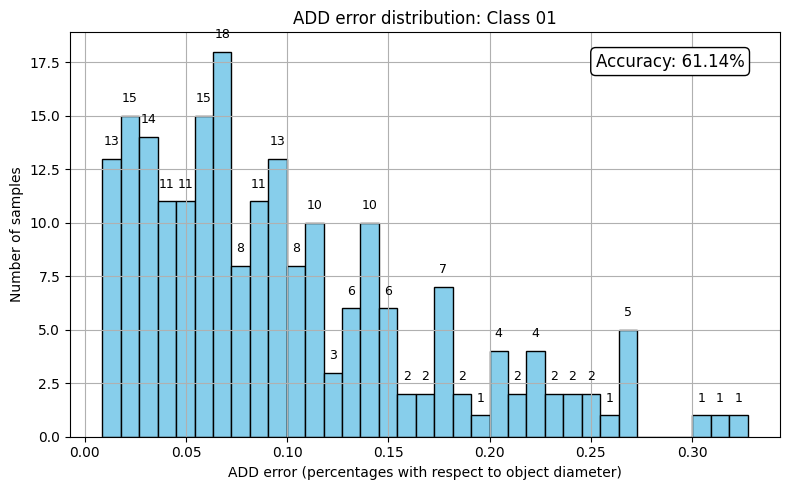

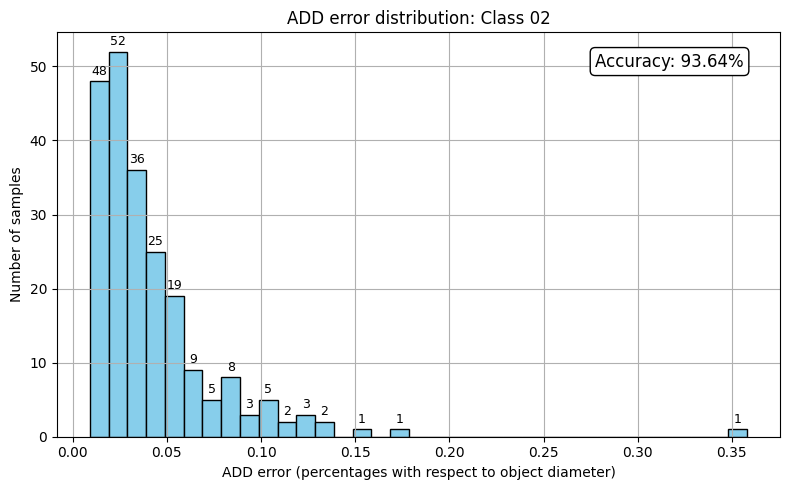

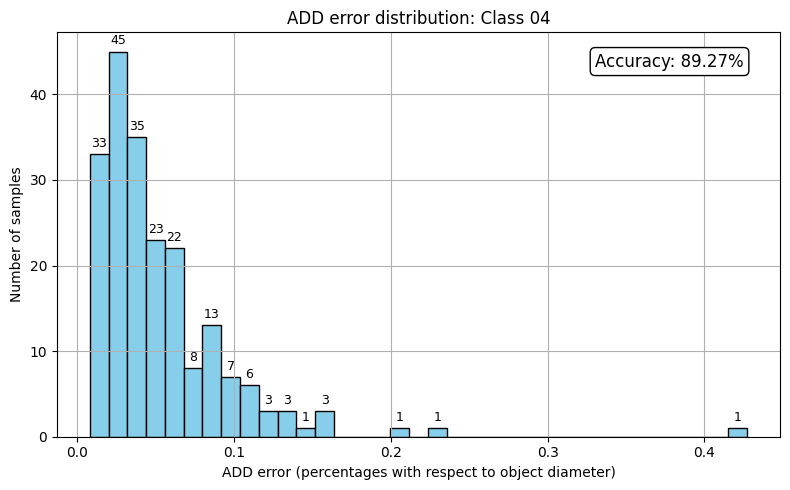

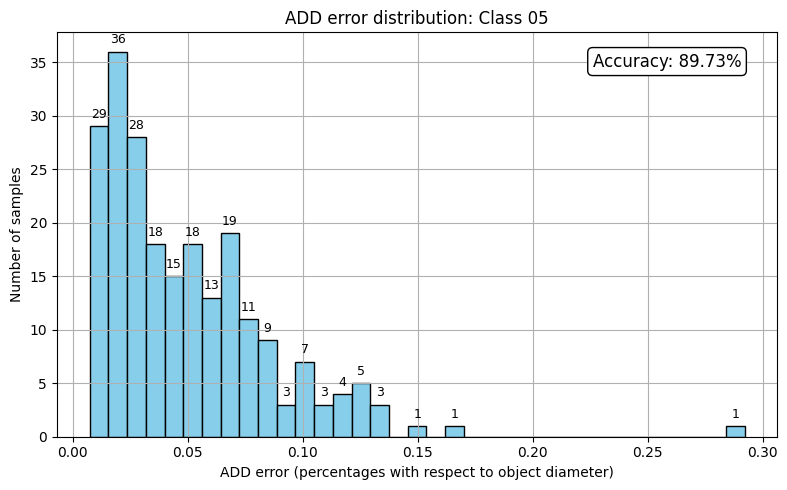

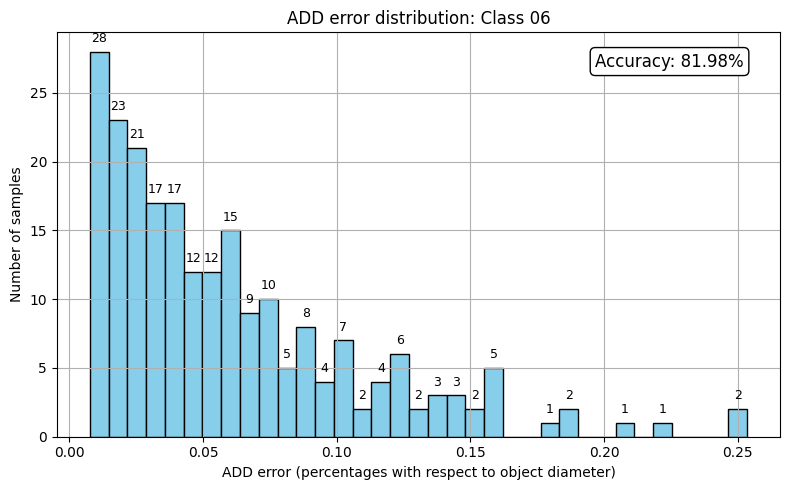

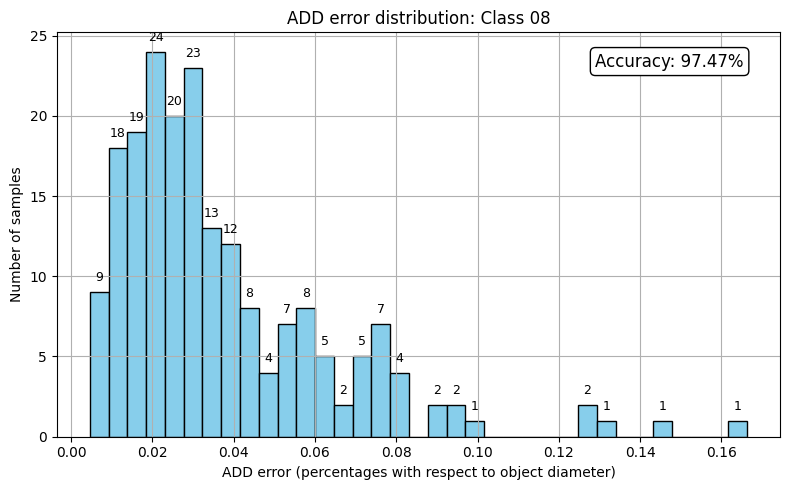

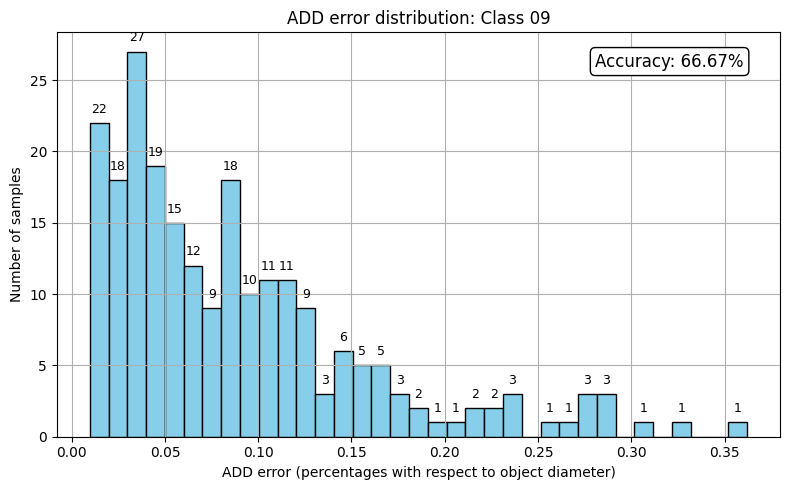

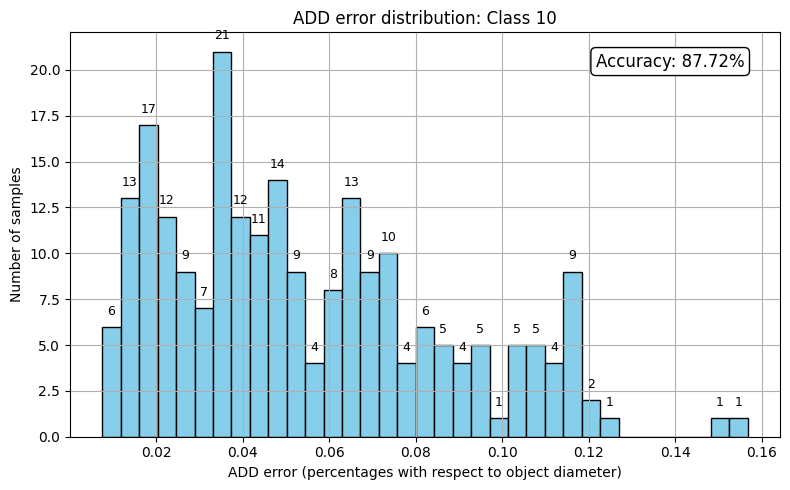

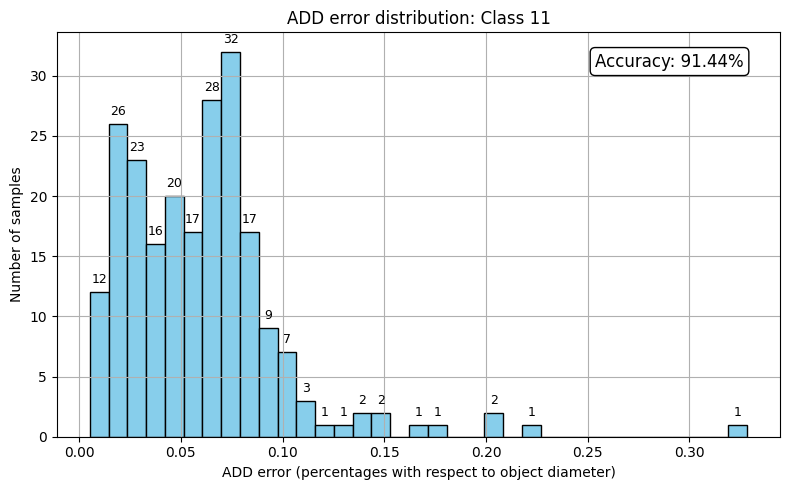

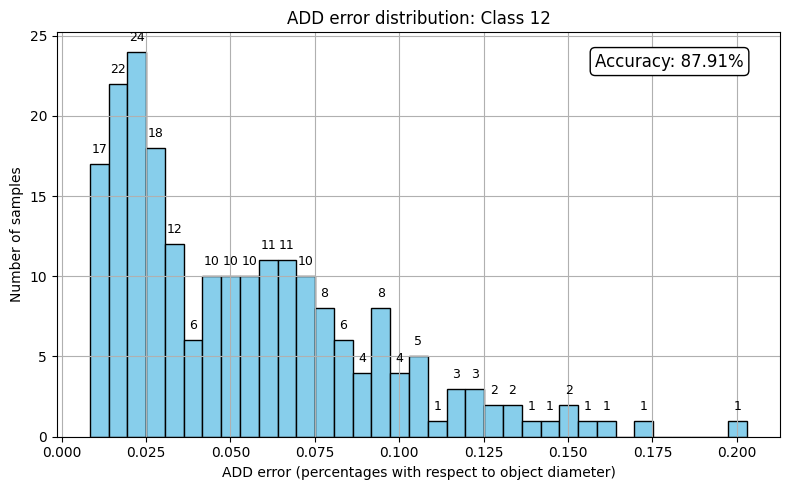

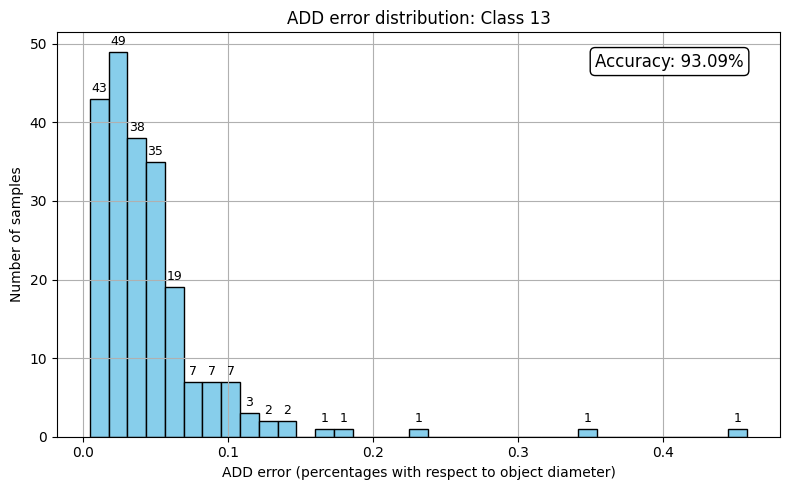

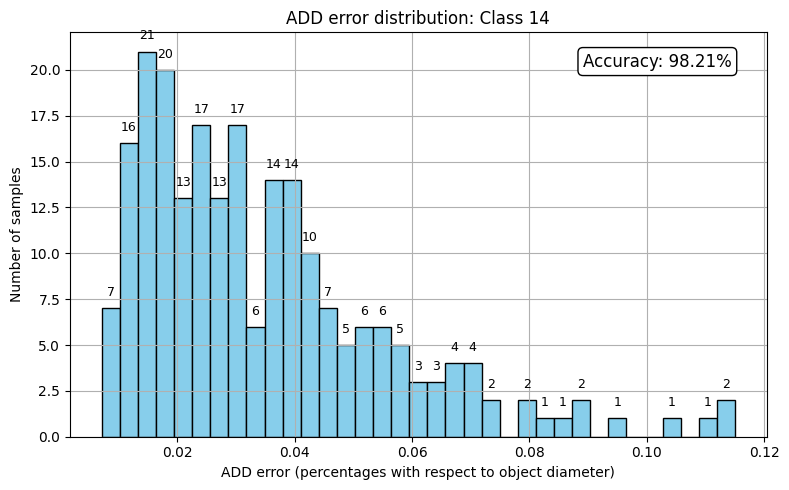

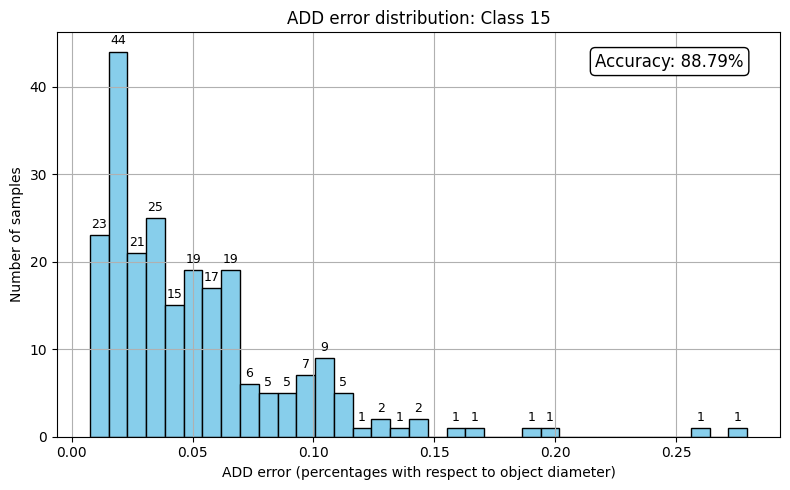

In [99]:
for cls in kp3d_50_fps.keys():
  plot_add_distribution(results_distribution_fps[cls], cls, accurracy_fps[cls])

In [90]:
def plot_add_cdf(add_errors, cls):
    sorted_errors = np.sort(add_errors)
    cumulative = np.arange(1, len(sorted_errors) + 1) / len(sorted_errors)

    plt.figure(figsize=(8, 5))
    plt.plot(sorted_errors, cumulative, color='blue', lw=2)
    plt.xlabel("ADD threeshold (with respect to object diameter))")
    plt.ylabel("Cumulative distribution")
    plt.title(f"CDF for {cls}")
    plt.grid(True)

    # Prikaz praga na 0.1
    plt.axvline(x=0.1, color='red', linestyle='--', label='Threshold = 0.1')
    acc_at_threshold = np.sum(sorted_errors < 0.1) / len(sorted_errors) * 100
    plt.text(0.1, 0.05, f"{acc_at_threshold:.2f}% under 0.1", color='red')

    plt.legend()
    plt.tight_layout()
    plt.show()


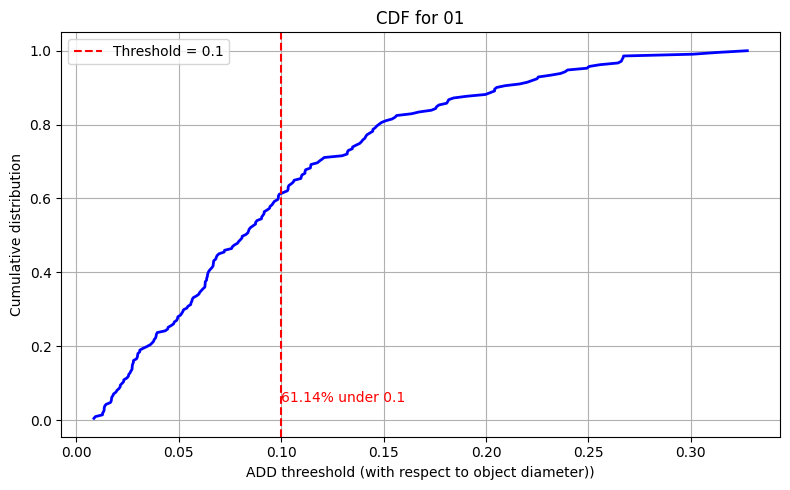

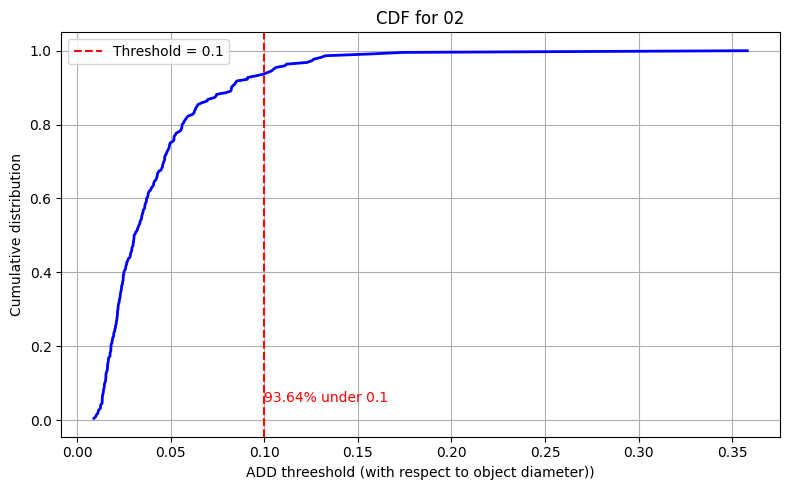

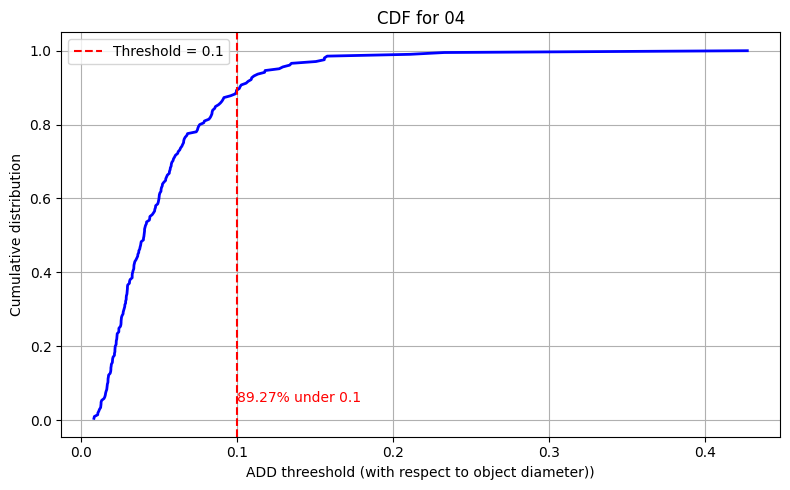

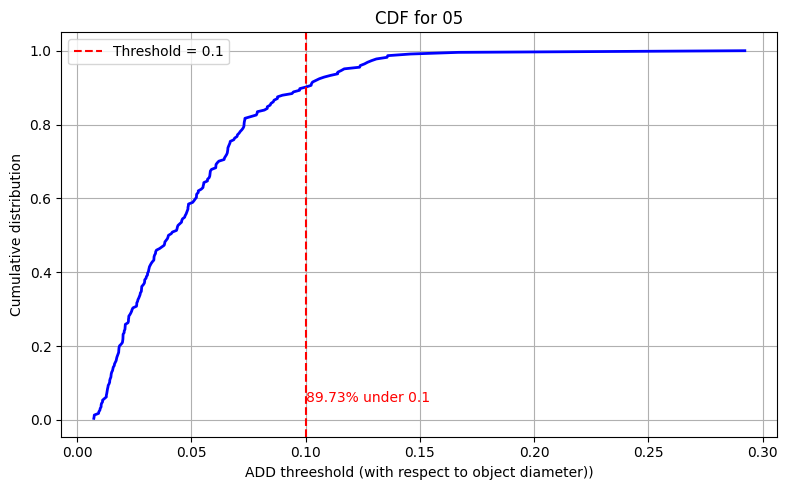

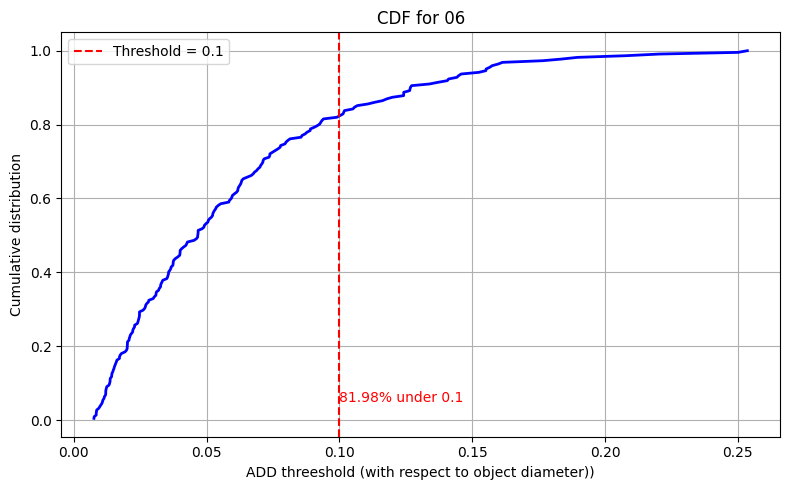

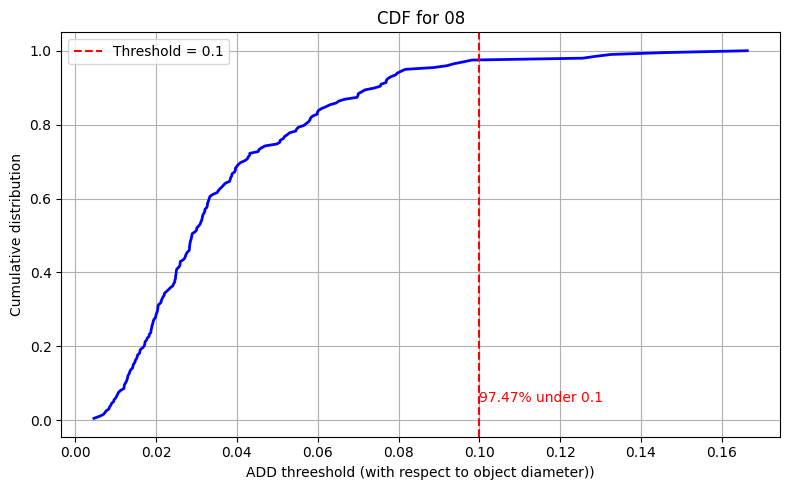

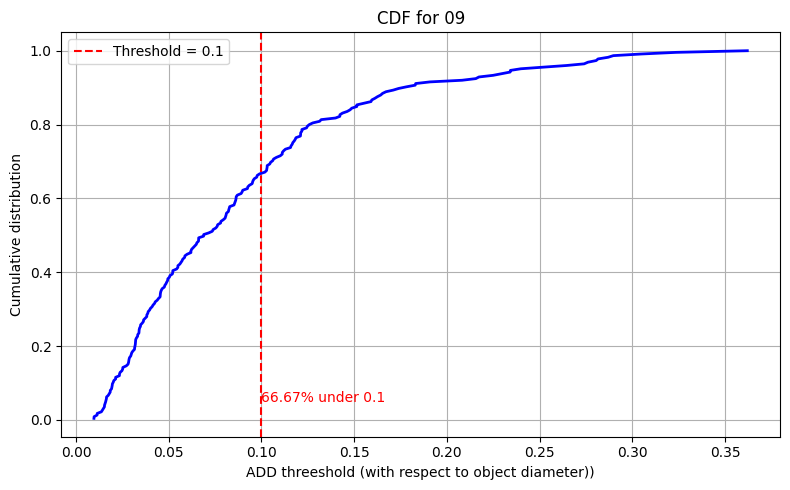

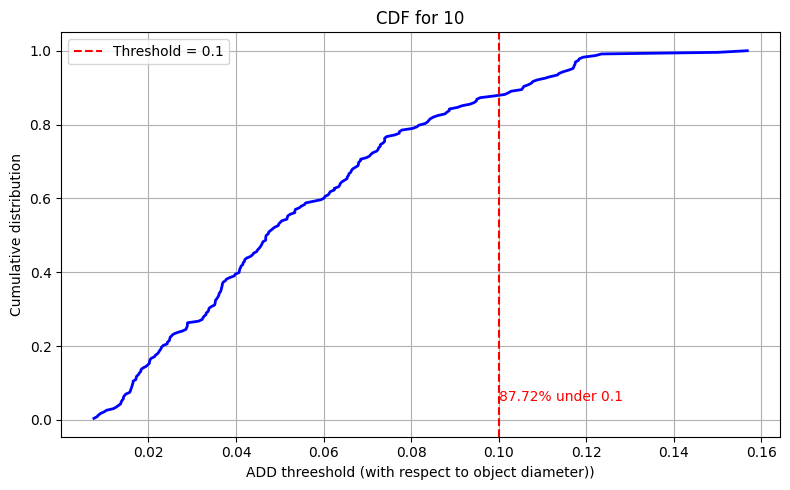

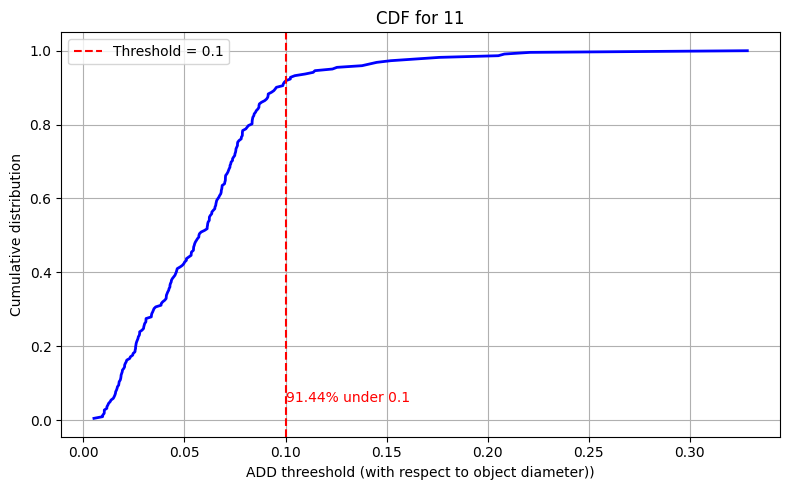

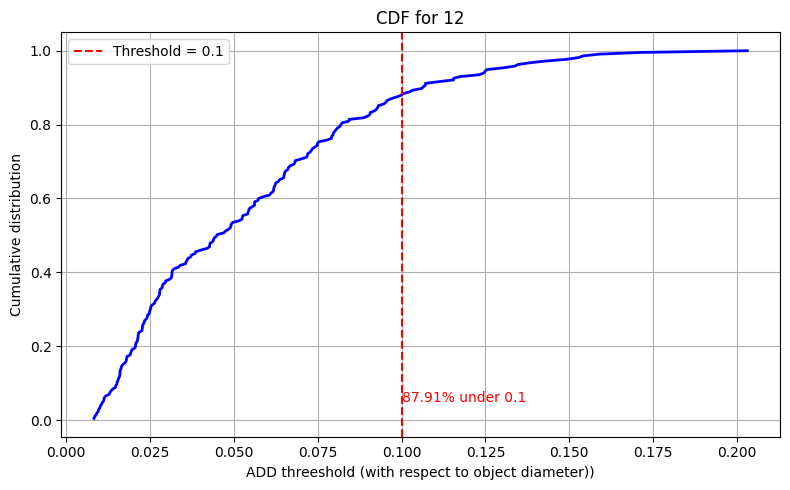

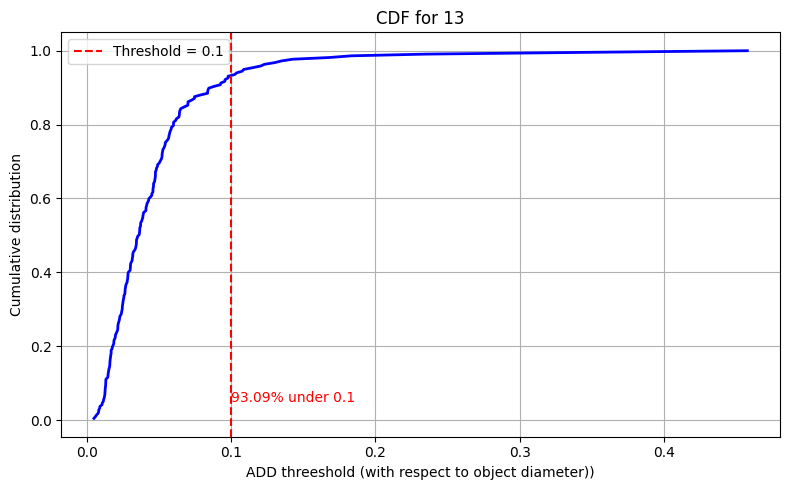

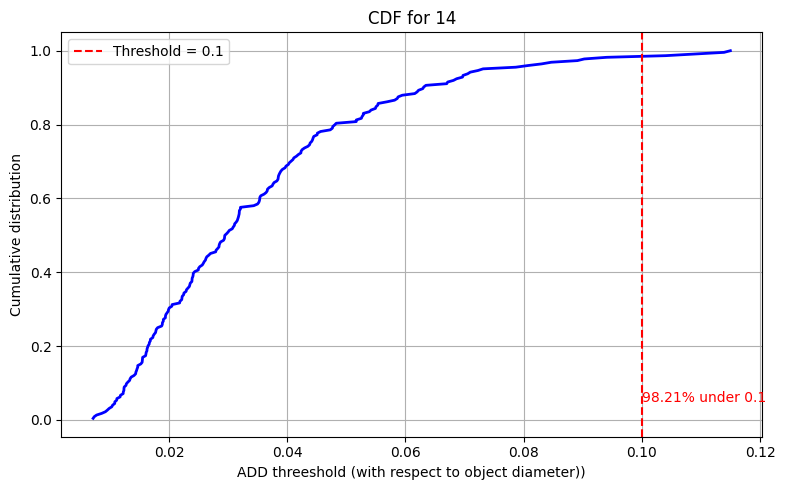

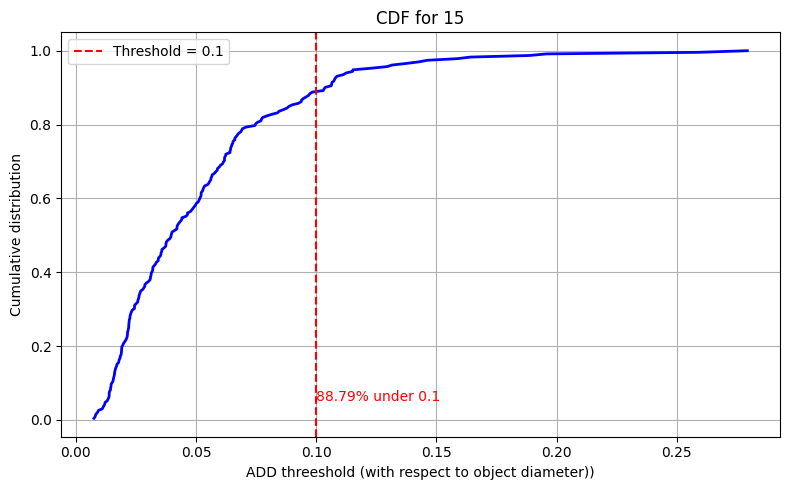

In [91]:
for cls in kp3d_50_fps.keys():
  plot_add_cdf(results_distribution_fps[cls], cls)

### **Observations:**

- Add Error distribution:

Most of the classes have performed very good results, with average accuracy of 84% for CPS data and 86.7% accuracy for FPS data. Although, classes 01 (ape) and 09 (duck) have performed accuracy slightly better than 60%. However, classes 01 (ape) and 09 (duck) achieved slightly above 60% accuracy. These two classes are known as very problematic in the LINEMOD dataset, primarily due to their geometric complexity and high symmetry.

ADD errors are represented with respect to the object diameter. Generally, the convention is to compare results with respect to object diameter. Pose prediction is considered correct if ADD is less thatn 10% of corresponding object diameter (in mm).

If we consider ADD error distribution, most of the classes have right skewed normal distribution.

For CFU curves, we can see that for some classes, increassing threeshold for just 0.01 or 0.02 would significantly improve results. (class 10, 11, 15)

For some classes that have very high accuracy class 13, 11 we have certain number of estimations that are big (30%, 40% of obj diameter). Those pictures should be analyzed.

### **Plotting poses for problematic estimations**

In [92]:
bboxes = {
    '01': {'min_x': -37.9343, 'min_y': -38.7996, 'min_z': -45.8845, 'size_x': 75.8686, 'size_y': 77.5992, 'size_z': 91.769},
    '02': {'min_x': -107.835, 'min_y': -60.9279, 'min_z': -109.705, 'size_x': 215.67, 'size_y': 121.8557, 'size_z': 219.41},
    '04': {'min_x': -68.3297, 'min_y': -71.5151, 'min_z': -50.2485, 'size_x': 136.6594, 'size_y': 143.0302, 'size_z': 100.497},
    '05': {'min_x': -50.3958, 'min_y': -90.8979, 'min_z': -96.867, 'size_x': 100.7916, 'size_y': 181.7958, 'size_z': 193.734},
    '06': {'min_x': -33.5054, 'min_y': -63.8165, 'min_z': -58.7283, 'size_x': 67.0107, 'size_y': 127.633, 'size_z': 117.4566},
    '08': {'min_x': -114.738, 'min_y': -37.7357, 'min_z': -104.001, 'size_x': 229.476, 'size_y': 75.4714, 'size_z': 208.002},
    '09': {'min_x': -52.2146, 'min_y': -38.7038, 'min_z': -42.8485, 'size_x': 104.4292, 'size_y': 77.4076, 'size_z': 85.697},
    '10': {'min_x': -75.0923, 'min_y': -53.5375, 'min_z': -34.6207, 'size_x': 150.1846, 'size_y': 107.075, 'size_z': 69.2414},
    '11': {'min_x': -18.3605, 'min_y': -38.933, 'min_z': -86.4079, 'size_x': 36.7211, 'size_y': 77.866, 'size_z': 172.8158},
    '12': {'min_x': -50.4439, 'min_y': -54.2485, 'min_z': -45.4, 'size_x': 100.8878, 'size_y': 108.497, 'size_z': 90.8},
    '13': {'min_x': -129.113, 'min_y': -59.241, 'min_z': -70.5662, 'size_x': 258.226, 'size_y': 118.4821, 'size_z': 141.1324},
    '14': {'min_x': -101.573, 'min_y': -58.8763, 'min_z': -106.558, 'size_x': 203.146, 'size_y': 117.7525, 'size_z': 213.116},
    '15': {'min_x': -46.9591, 'min_y': -73.7167, 'min_z': -92.3737, 'size_x': 93.9181, 'size_y': 147.4334, 'size_z': 184.7474}
}

K = np.array([
    [572.4114,   0.0,      325.2611],
    [  0.0,    573.57043,  242.04899],
    [  0.0,      0.0,        1.0   ]
], dtype=np.float64)

IMG_DIR = os.path.join(BASE_DIR, "data/full_data/train/images")

# Boje
COLOR_PRED = (0, 255, 0)   # zeleno
COLOR_GT = (255, 0, 0)     # plavo





In [93]:
def get_bbox_points(bbox):
  x, y, z = bbox['min_x'], bbox['min_y'], bbox['min_z']
  dx, dy, dz = bbox['size_x'], bbox['size_y'], bbox['size_z']
  return np.array([
      [x,     y,     z],
      [x+dx,  y,     z],
      [x+dx,  y+dy,  z],
      [x,     y+dy,  z],
      [x,     y,     z+dz],
      [x+dx,  y,     z+dz],
      [x+dx,  y+dy,  z+dz],
      [x,     y+dy,  z+dz]
  ], dtype=np.float32)


In [94]:
def draw_bbox(img, pts, color=(0, 255, 0)):
  pts = pts.astype(int)
  for i, j in zip([0,1,2,3], [1,2,3,0]):
      cv2.line(img, pts[i], pts[j], color, 2)
  for i, j in zip([4,5,6,7], [5,6,7,4]):
      cv2.line(img, pts[i], pts[j], color, 2)
  for i, j in zip(range(4), range(4, 8)):
      cv2.line(img, pts[i], pts[j], color, 2)

In [121]:
high_error_samples_fps

defaultdict(list,
            {'01': [('01_0096', np.float64(33.44273329945054)),
              ('01_1192', np.float64(31.932642373516522)),
              ('01_0464', np.float64(30.715966457283525)),
              ('01_0325', np.float64(27.273891778461547)),
              ('01_0494', np.float64(27.250811001789554)),
              ('01_1018', np.float64(27.201711547744978)),
              ('01_0328', np.float64(27.16440462170635)),
              ('01_0717', np.float64(26.998140893867706)),
              ('01_0234', np.float64(26.09001748334427)),
              ('01_0816', np.float64(25.55908747163799)),
              ('01_0068', np.float64(25.449386854397858)),
              ('01_0334', np.float64(24.48379443338786)),
              ('01_0240', np.float64(24.363614912864374)),
              ('01_0900', np.float64(24.136159328752168)),
              ('01_0317', np.float64(23.631230111056922)),
              ('01_0484', np.float64(23.025125763558364)),
              ('01_0473', np.float64(

In [135]:
high_error_samples_fps["02"]

[('02_0867', np.float64(88.63158694006717)),
 ('02_0772', np.float64(43.20047489948904)),
 ('02_0916', np.float64(38.462172022552046)),
 ('02_0704', np.float64(32.82414453070613)),
 ('02_0705', np.float64(32.25012491199087)),
 ('02_0541', np.float64(31.33096119440209)),
 ('02_0884', np.float64(31.040010496864028)),
 ('02_0963', np.float64(30.38796982343882)),
 ('02_0832', np.float64(27.72721912285557)),
 ('02_0110', np.float64(27.47915555542144)),
 ('02_0487', np.float64(26.291226036961024)),
 ('02_0502', np.float64(25.98114490635979)),
 ('02_0748', np.float64(25.759220497450883)),
 ('02_0542', np.float64(25.182803110391827))]

[[  19.34730307]
 [ -93.81455751]
 [1001.17546465]] [[  20.191229]
 [ -94.51236 ]
 [1034.5956  ]]


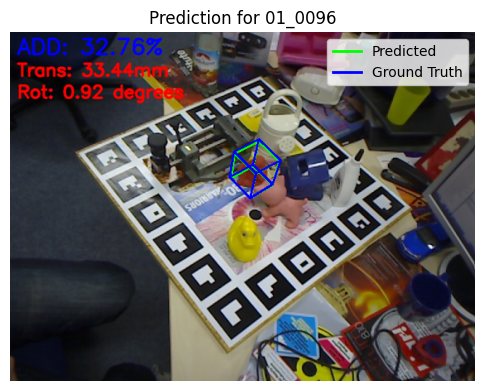

[[ 51.71058392]
 [ 48.34253916]
 [968.31101688]] [[  54.411964]
 [  50.794933]
 [1001.3227  ]]


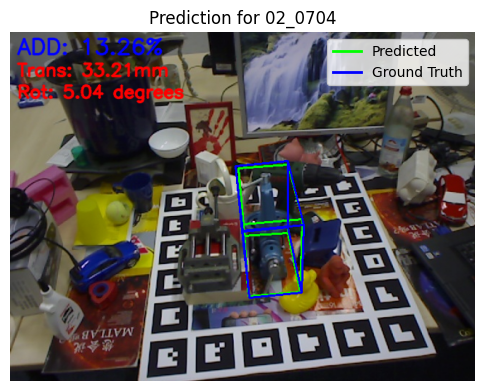

[[  81.25739521]
 [ 103.88350562]
 [1028.6647478 ]] [[  85.682365]
 [ 108.53262 ]
 [1054.779   ]]


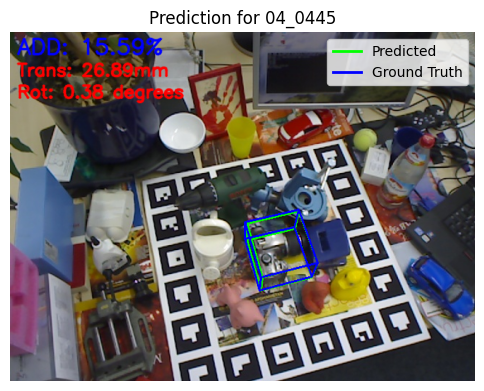

[[-58.50157948]
 [-25.79963093]
 [973.57372305]] [[ -63.75029]
 [ -27.31171]
 [1032.6178 ]]


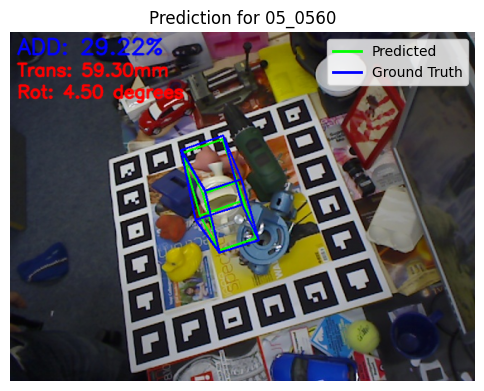

[[128.06493   ]
 [ 33.16136774]
 [909.51519004]] [[124.66523]
 [ 32.4988 ]
 [875.2821 ]]


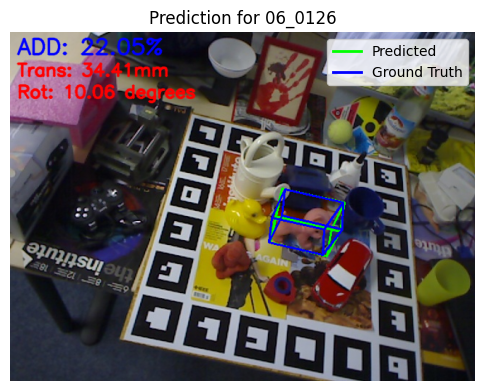

[[-21.47232239]
 [-18.00572066]
 [964.23119778]] [[ -19.323114]
 [ -12.298033]
 [1006.7066  ]]


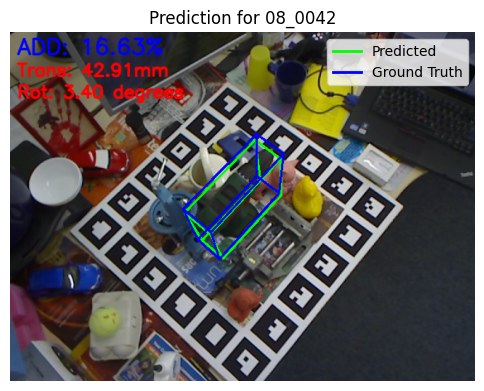

[[  47.32765562]
 [-133.13783192]
 [ 938.99274998]] [[  49.957546]
 [-136.55748 ]
 [ 969.7336  ]]


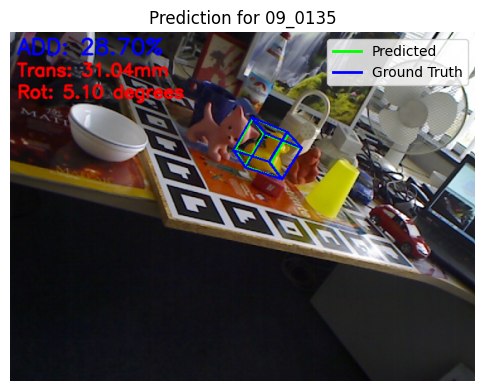

[[  52.29794873]
 [  19.86558642]
 [1025.56297589]] [[  54.080738]
 [  21.40707 ]
 [1051.5518  ]]


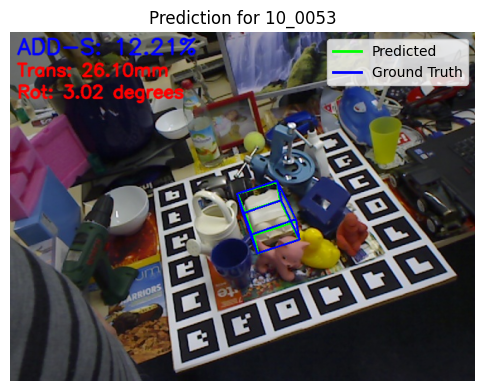

[[  63.72063369]
 [-113.94721043]
 [ 872.09538471]] [[  69.83951 ]
 [-122.198364]
 [ 953.59045 ]]


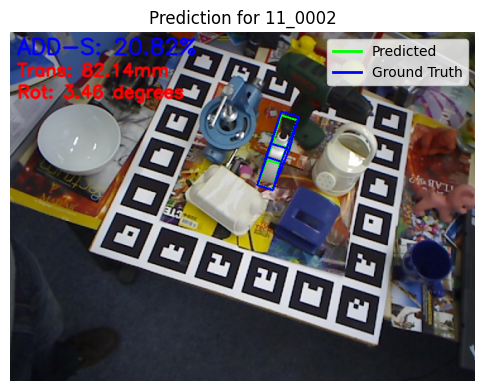

[[ -91.50817745]
 [-113.39783213]
 [ 715.49374855]] [[ -94.908714]
 [-116.07396 ]
 [ 739.71    ]]


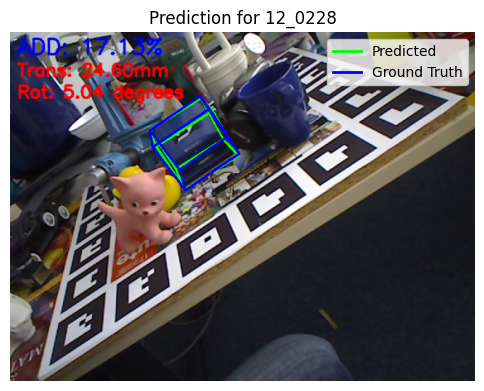

[[-26.8844232 ]
 [  1.33991163]
 [792.58457206]] [[-13.532736 ]
 [ -3.0828714]
 [743.70166  ]]


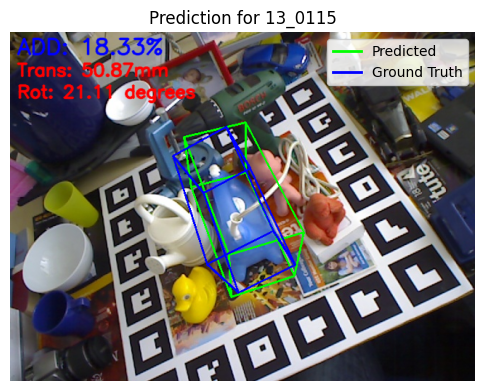

[[ 88.8142101 ]
 [ 77.67550422]
 [955.83909176]] [[ 93.74084]
 [ 87.19412]
 [985.881  ]]


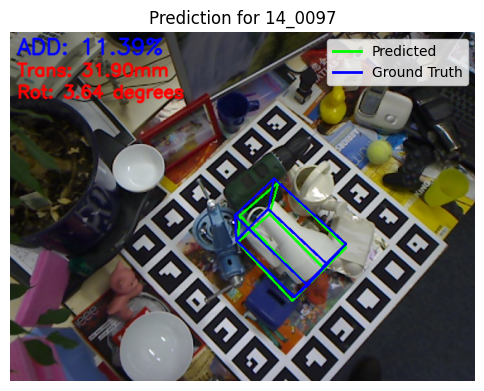

[[  53.12779006]
 [-204.54223566]
 [ 994.22398434]] [[  57.610134]
 [-209.88293 ]
 [1028.3257  ]]


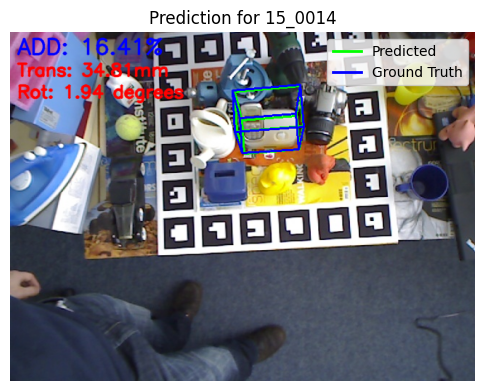

In [143]:
plotted_classes = set()

for img_id, result_list in pnp_results_pred_fps.items():
    cls = img_id.split('_')[0]  # '06_0670' → '06'

    if img_id not in np.array(high_error_samples_fps[cls])[:5, 0]:
        continue

    if cls in plotted_classes:
        continue  # već prikazana ta klasa
    plotted_classes.add(cls)

    # 3D bounding box te klase
    bbox = bboxes[cls]

    # Predikcija
    R_pred = np.array(result_list[0]['R'], dtype=np.float32)
    t_pred = np.array(result_list[0]['t'], dtype=np.float32).reshape(3, 1)
    rvec_pred, _ = cv2.Rodrigues(R_pred)

    # 3D BBox tačke i njihova projekcija (predikcija)
    points_3d = get_bbox_points(bbox)
    points_2d_pred, _ = cv2.projectPoints(points_3d, rvec_pred, t_pred, K, None)
    points_2d_pred = points_2d_pred.squeeze()

    # Ground truth
    try:
        R_gt, t_gt = get_gt_pose(img_id)
    except KeyError:
        continue
    rvec_gt, _ = cv2.Rodrigues(R_gt)
    points_2d_gt, _ = cv2.projectPoints(points_3d, rvec_gt, t_gt, K, None)
    points_2d_gt = points_2d_gt.squeeze()

    # Izračunavanje ADD / ADD-S greške
    pts3d = np.array(kp3d_50_fps[cls], dtype=np.float32)  # (N, 3)
    gt_tr = (R_gt @ pts3d.T + t_gt).T                     # (N, 3)
    pnp_tr = (R_pred @ pts3d.T + t_pred).T                # (N, 3)

    if cls in symmetric_objects:
        add_err = np.mean([
            np.min(np.linalg.norm(gt_point - pnp_tr, axis=1))
            for gt_point in gt_tr
        ])
        label = "ADD-S"
    else:
        add_err = np.mean(np.linalg.norm(gt_tr - pnp_tr, axis=1))
        label = "ADD"


    # Dobijanje transl error
    transl_err = np.linalg.norm(t_gt - t_pred)

    print(t_gt, t_pred)

    #Dobijanje rotacione greske
    R_diff = R_gt @ R_pred.T
    cos_theta = (np.trace(R_diff) - 1) / 2
    cos_theta = np.clip(cos_theta, -1.0, 1.0)  # izbegni NaN zbog numeričkih grešaka
    angle_rad = np.arccos(cos_theta)
    rot_err_deg = np.degrees(angle_rad)


    # Normalizacija u odnosu na prečnik objekta
    add_err_percent = 100 * add_err / diameter_map[cls]

    # Učitavanje slike
    img_path = os.path.join(IMG_DIR, f"{img_id}.png")
    img = cv2.imread(img_path)
    if img is None:
        print(f"Image not found: {img_path}")
        continue

    # Iscrtavanje ADD vrednosti na slici
    text = f"{label}: {add_err_percent:.2f}%"
    cv2.putText(img, text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX,
                1.0, (255, 0, 0), 2, cv2.LINE_AA)


    cv2.putText(img, f"Trans: {transl_err:.2f}mm", (10, 60),
            cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2, cv2.LINE_AA)

    cv2.putText(img, f"Rot: {rot_err_deg:.2f} degrees", (10, 90),
                cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2, cv2.LINE_AA)

    # Iscrtavanje predikcije i ground truth BBox-a
    draw_bbox(img, points_2d_pred, color=COLOR_PRED)
    draw_bbox(img, points_2d_gt, color=COLOR_GT)

    # Prikaz slike
    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(f"Prediction for {img_id}")
    legend_elements = [
        Line2D([0], [0], color=(0, 1, 0), lw=2, label='Predicted'),
        Line2D([0], [0], color=(0, 0, 1), lw=2, label='Ground Truth')
    ]
    plt.legend(handles=legend_elements, loc='upper right')
    plt.axis("off")
    plt.show()


In [115]:
high_error_samples_fps

# Putevi do slika (prilagodi!)
image_path_template = ""  # npr. images/class_06.jpg
plotted_classed = set()

# Funkcija za iscrtavanje BBox-a i projekciju
for key, result in pnp_results_pred_fps.items():
  class_id = key.split('_')[0]  # npr. '06_0670' → '06'

  if class_id in plotted_classed:
    continue  # već prikazana ta klasa → preskoči

  plotted_classed.add(class_id)

  #3D boxes
  bbox = bboxes[class_id]

  R_pred = np.array(result[0]['R'])
  t_pred = np.array(result[0]['t']).reshape(3, 1)

  #converting R_pred matrix to appropirate form for applying projectPoints function from cv2
  rvec, _ = cv2.Rodrigues(R_pred)

  # prepearing 3d box data
  points_3d = get_bbox_points(bbox)

  #PREDICTED POINTS
  points_2d, _ = cv2.projectPoints(points_3d, rvec, t_pred, K, None)
  points_2d = points_2d.squeeze()

  # GROUND TRUTH
  R_gt, t_gt = get_gt_pose(key)
  rvec_gt, _ = cv2.Rodrigues(R_gt)
  points_2d_gt, _ = cv2.projectPoints(points_3d, rvec_gt, t_gt, K, None)
  points_2d_gt = points_2d_gt.squeeze()


  #GETTING ADD VALUES:
  ######
  pts3d = np.array(kp3d_50_fps[cls], dtype=np.float32)  # (N,3)
  gt_tr  = (R_gt @ pts3d.T + t_gt).T                 # (N,3)
  pnp_tr = (R_pred @ pts3d.T + t_pred).T                 # (N,3)

  if class_id in symmetric_objects:
    add_s_err = np.mean([
        np.min(np.linalg.norm(gt_point - pnp_tr, axis=1))
        for gt_point in gt_tr
    ])
    add_err = add_s_err
  else:
    add_err = np.mean(np.linalg.norm(gt_tr - pnp_tr, axis=1))


  #with respect to the object diameter
  add_err = 100*add_err/diameter_map[cls]



  # Putanja do slike (prilagodi ako je potrebno)
  img_path = os.path.join(IMG_DIR, f"{key}.png")
  img = cv2.imread(img_path)


  label = "ADD-S" if class_id in symmetric_objects else "ADD"
  text = f"{label}: {add_err:.2f}%"
  cv2.putText(
      img,
      text,
      (10, 30),
      cv2.FONT_HERSHEY_SIMPLEX,
      1.0,
      (255, 0, 0),
      2,
      cv2.LINE_AA
  )

  draw_bbox(img, points_2d, color=COLOR_PRED)
  draw_bbox(img, points_2d_gt, color=COLOR_GT)

  # Prikaz
  plt.figure(figsize=(6, 6))
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  plt.title(f"Prediction for {key}")

  legend_elements = [
    Line2D([0], [0], color=(0,1,0), lw=2, label='Predicted'),
    Line2D([0], [0], color=(0,0,1), lw=2, label='Ground Truth')
  ]
  plt.legend(handles=legend_elements, loc='upper right')
  plt.axis("off")
  plt.show()